# Predicting views using SplitAE

In [15]:
import numpy as np
import torch
from mvlearn.embed import SplitAE
import matplotlib.pyplot as plt
import sklearn.cross_decomposition
plt.style.use("ggplot")
%config InlineBackend.figure_format = 'svg'

In [16]:
# cca, previously validated against sklearn CCA
def cca(X, Y, regularizationλ=0):

    X = X - X.mean(axis=0)
    Y = Y - Y.mean(axis=0)
    k = min(X.shape[1], Y.shape[1])
    covXX = (X.t() @ X) / X.shape[0] + regularizationλ*torch.eye(X.shape[1], device=X.device)
    covYY = (Y.t() @ Y) / X.shape[0] + regularizationλ*torch.eye(Y.shape[1], device=X.device)
    covXY = (X.t() @ Y) / X.shape[0]

    U_x, S_x, V_x = covXX.svd()
    U_y, S_y, V_y = covYY.svd()
    covXXinvHalf = V_x @ (S_x.sqrt().reciprocal().diag()) @ U_x.t()
    covYYinvHalf = V_y @ (S_y.sqrt().reciprocal().diag()) @ U_y.t()
    T = covXXinvHalf @ covXY @ covYYinvHalf
    U, S, V = T.svd()
    A = covXXinvHalf @ U[:, :k]
    B = covYYinvHalf @ V[:, :k]
    return A.t(), B.t(), S

### Predicting a held out view with CCA, nonlinear relationship between views

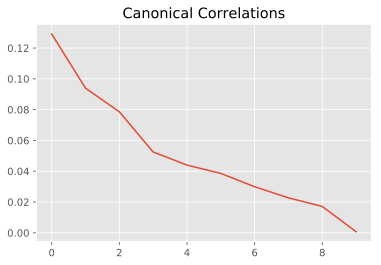

In [17]:
# The relationship between view1 and view2 is that view2(t) = view1(t) ** 2. 
# In words, View1(t) is a nonlinear function of View2(t)
view1 = np.random.randn(10000, 10)
view2 = view1 ** 2
# view2 = view1 @ np.random.randn(10, 10)

# Let's say now say we have 10,000 points with a view1 but only 5000 of those points have a view 2. So
# one obvious goal is to somehow reconstruct the missing view2 data for those points.
view1Train = view1[:5000]
view2Train = view2[:5000]
view1Test = view1[5000:]
view2Test = view2[5000:] # these are what we're trying to predict

# Let's try and predict view2Test with CCA
U, V, S = cca(torch.FloatTensor(view1Train), torch.FloatTensor(view2Train))
view1CCs = view1Train @ U.t().numpy()
view2CCs = view2Train @ V.t().numpy()
covariance = np.mean((view1CCs - view1CCs.mean(axis=0)) * (view2CCs - view2CCs.mean(axis=0)), axis=0)
stdprod = np.std(view1CCs, axis=0) * np.std(view2CCs, axis=0)
correlations = covariance / stdprod

# we can see that the canonical correlations are very low. This means that for any given sample, the
# vector of view1 canonical variables will not be close to the vector of view2 canonical variables.
# Ideally the canonical correlations would be 1, so that the for each point, each view's canonical variable
# has the same vlaue.
plt.plot(correlations)
plt.title("Canonical Correlations")
plt.show()

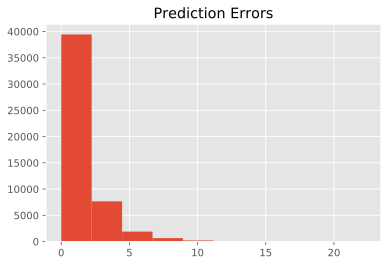

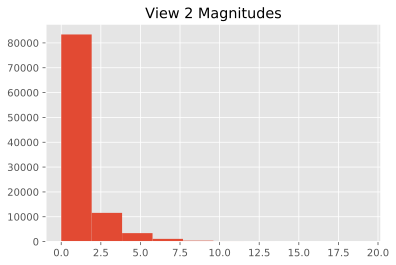

MSE Loss is  5.096770717383144


In [18]:
# This is how we predict our training data given the canonical variables
view1TrainPred = view1CCs @ np.linalg.inv(U.t().numpy())
view2TrainPred = view2CCs @ np.linalg.inv(V.t().numpy())
assert np.all(view1TrainPred - view1Train < 1e-2)
assert np.all(view2TrainPred - view2Train < 1e-2)

# This is how we predict View2 from View1 values. Notice the V.t() matrix being used for view1 values.
view1TestCCs = view1Test @ U.t().numpy()
view2TestPred = view1TestCCs @ np.linalg.inv(V.t().numpy())

# Notice that the magnitude of the errors are close to the magnitude of the view2 elements themselves!
# these are bad predictions.
predictionErrors = np.abs(view2TestPred - view2Test).ravel()
plt.hist(predictionErrors)
plt.title("Prediction Errors")
plt.show()
plt.hist(view2.ravel())
plt.title("View 2 Magnitudes")
plt.show()

print("MSE Loss is ", np.mean((view2TestPred - view2Test)**2))

# If you repeat this experiment with view2 = (some linear combination of the features of view1),
# for example view2 = view1 @ np.random.randn(10, 10)
# the prediction errors will be zero. This is where CCA exceeds, when the above is true. We will see this 
# next time we run CCA.

### Predicting a held out view with SplitAE, nonlinear relationship between views

Parameter counts: 
view1Encoder: 1,012
view1Decoder: 1,002
view2Decoder: 1,002


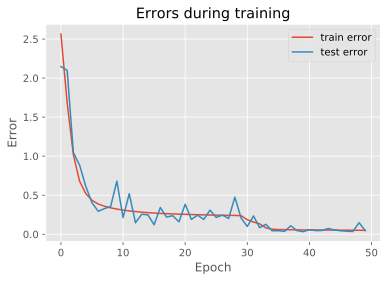

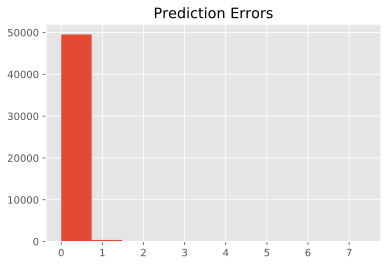

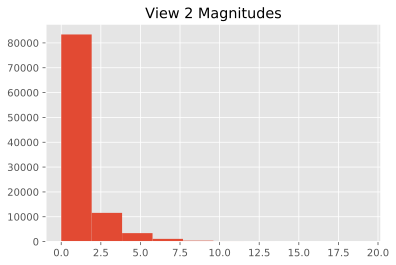

MSE Loss is  0.052350855326646545


In [19]:
# Now lets try the same thing with SplitAE!
splitae = SplitAE(hidden_size=32, num_hidden_layers=1, embed_size=20, training_epochs=50, batch_size=32, learning_rate=0.01, print_info=False, print_graph=True)
splitae.fit([view1Train, view2Train], validationXs=[view1Test, view2Test])

# (I'm using the test data to see validation loss, in a real case the validation set is held out data and the test set is unknown / not used until the end)
embeddings, reconstructedView1, predictedView2 = splitae.transform([view1Test])
predictionErrors = np.abs(predictedView2 - view2Test).ravel()
plt.hist(predictionErrors)
plt.title("Prediction Errors")
plt.show()
plt.hist(view2.ravel())
plt.title("View 2 Magnitudes")
plt.show()

print("MSE Loss is ", np.mean((predictedView2 - view2Test)**2))

# The bins near 0 are a bit deceiving on the histograms, but the loss shows it all -- with splitAE we can 
# predict our view2 from view1 with much higher accuracy than CCA.
# The tradeoff here was hyperparameter tuning -- I had to get the embed size right, the number of hidden layers right
# (too big, and the loss will converge to something higher), and train for the right amount of time.

### Predicting a held out view with CCA, linear relationship between views, few data points

In [20]:
# Lets say instead of 5000 input points we only have 50 train points and 50 test points. And that this time,
# we have a generally linear relationship.
view1 = np.random.randn(100, 10)
view2 = view1 @ np.random.randn(10, 10)

view1Train = view1[:50]
view2Train = view2[:50]
view1Test = view1[50:]
view2Test = view2[50:] # these are what we're trying to predict

U, V, S = cca(torch.FloatTensor(view1Train), torch.FloatTensor(view2Train))
view1TestCCs = view1Test @ U.t().numpy()
view2TestPred = view1TestCCs @ np.linalg.inv(V.t().numpy())
print("MSE Loss is ", np.mean((view2TestPred - view2Test)**2))

# CCA achieves a loss of ~0. Can splitAE achieve the same?

MSE Loss is  2.517854473585315e-11


### Predicting a held out view with SplitAE, linear relationship between views, few data points

Parameter counts: 
view1Encoder: 2,068
view1Decoder: 2,058
view2Decoder: 2,058


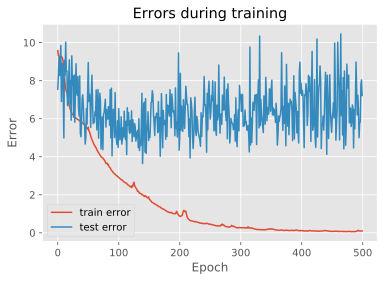

MSE Loss for test data  5.59877941169036
MSE Loss for train data  0.06715857622620428
MSE Loss when predicting mean 8.489032078377859


In [21]:
splitae = SplitAE(hidden_size=32, num_hidden_layers=2, embed_size=20, training_epochs=500, batch_size=10, learning_rate=0.01, print_info=False, print_graph=True)
splitae.fit([view1Train, view2Train], validationXs=[view1Test, view2Test])
embeddings, reconstructedView1, predictedView2 = splitae.transform([view1Test]) # using test data

print("MSE Loss for test data ", np.mean((predictedView2 - view2Test)**2))
embeddings, reconstructedView1, predictedView2 = splitae.transform([view1Train]) # using training data
print("MSE Loss for train data ", np.mean((predictedView2 - view2Train)**2))
print("MSE Loss when predicting mean", np.mean((0 - view2Train)**2))

# Clearly we have overfit, and from the graph we can see that we have done so within the first dozen epochs.
# Our test error is almost as bad a just predicting the mean. Can further tuning the parameters s.t.
# we don't overfit allow us to match CCA performance?

Parameter counts: 
view1Encoder: 220
view1Decoder: 210
view2Decoder: 210


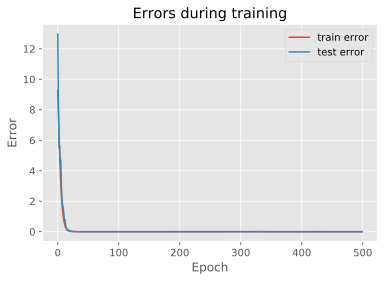

MSE Loss for test data  0.00038991122173028984


In [22]:
splitae = SplitAE(hidden_size=32, num_hidden_layers=0, embed_size=20, training_epochs=500, batch_size=10, learning_rate=0.01, print_info=False, print_graph=True)
splitae.fit([view1Train, view2Train], validationXs=[view1Test, view2Test])
embeddings, reconstructedView1, predictedView2 = splitae.transform([view1Test]) # using test data
print("MSE Loss for test data ", np.mean((predictedView2 - view2Test)**2))

# Luckily, by converting our model to a linear one (i.e. numHiddenLayers=0, so no activations are performed) 
# we have once again predicted the test data correctly.
# But the trade-off here is clear. CCA has performed maybe 10 matrix operations. SplitAE has performed at least 
# 500*2 = 1000 equivalent matrix operations. 
# Using %%timeit, 
# - CCA takes ~600us to predict view2Test. 
# - SplitAE takes ~4.5s (7,000x slower) to predict view2Test 